# Aspect Identifying
### Running through the tweets, based on Harry Wang's Document Clustering 
###### 7/6 - Assigment 4
<p> We take the tweets out of the data, clean them of html, hashtags and mentions, then run the text through a tokenizer before identifying the most common words/phrases throughout the tweets. Those common words/phrases are then the aspects we base the clustering of the tweets on. As of right now, the model is using singular terms with a fixed dictionary, the hope is to move towards a dynamic dictionary that grows with the new data recieved.</p>

###### 7/12 - Assigment 5
<p>We are now showing the top 10 words per cluster and doing postprocessing on those words for cluster assignment. Instead of trying to assign one cluster at first, each tweet has been given a cluster ranking, indicating how much of a cluster each one is assigned to (a percentage out of 100). Also, we have added in clustering by k-means to determine the amount of clusters there should be through a scientific and data-driven approach, rather than 5 for convenience.</p>

In [1]:
import preprocessor as p #https://pypi.org/project/tweet-preprocessor/
import numpy as np
import pandas as pd
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import string
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

Read the tweets

In [2]:
df = pd.read_csv('data/Tweets.csv')
tweets = df.text

In [3]:
len(tweets)

14640

In [4]:
tweet = tweets[0]

In [5]:
tweet

'@VirginAmerica What @dhepburn said.'

In [6]:
tweet = p.clean(tweet)

In [7]:
tweet

'What said.'

In [8]:
#tweets

In [9]:
new_tweets = []
for tweet in tweets:
    tweet = BeautifulSoup(tweet, 'html.parser').getText()
    tweet = p.clean(tweet)
    new_tweets.append(tweet)

In [10]:
tweets = new_tweets
#tweets

In [11]:
stopwords = nltk.corpus.stopwords.words('english')

stemmer = SnowballStemmer("english")

In [12]:
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [13]:
def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [14]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in tweets:
    allwords_stemmed = tokenize_and_stem(i) # for each item in 'tweets', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) # extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [15]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [16]:
#https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=10,
                                   stop_words='english', max_features=10000,
                                   strip_accents='unicode', use_idf=True, 
                                   tokenizer=tokenize_and_stem, ngram_range=(2,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(tweets) #fit the vectorizer to tweets

C:\Code\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Wall time: 9.86 s


In [18]:
terms = tfidf_vectorizer.get_feature_names()
tfidf_vectorizer.fit(tweets)
text = tfidf_vectorizer.transform(tweets)

C:\Code\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters


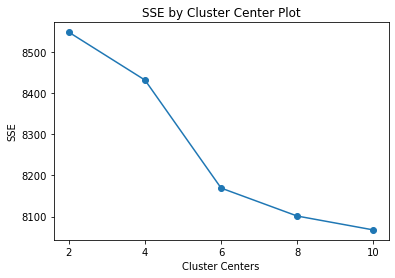

In [19]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 10)

In [20]:
cluster_amt = 6

In [21]:
clusters = MiniBatchKMeans(n_clusters=cluster_amt, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

In [22]:
clusters

array([1, 1, 1, ..., 1, 1, 1])

In [23]:
from sklearn.cluster import KMeans

num_clusters = cluster_amt

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 1.45 s


In [24]:
Tweets = { 'tweet': tweets, 'cluster': clusters }

frame = pd.DataFrame(Tweets, clusters)
#frame = pd.DataFrame(Tweets, index = [clusters])

#print(frame)

frame['cluster'].value_counts() #number of tweets per cluster (clusters from 0 to 4)


0    13477
3      486
1      320
5      186
4      144
2       27
Name: cluster, dtype: int64

In [25]:
clusterwords = pd.DataFrame(columns = ['Cluster', 'Word', "Name"])

In [26]:
print("Top terms per cluster:")

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(cluster_amt):
    print("Cluster %d words:" % i, end='')
    name = "Cluster %d words:" % i
    
    for ind in order_centroids[i, :10]:
        word = ' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0]
        print(word, end=',')
        clusterwords.loc[len(clusterwords.index)] = [i, word, "Miscellaneous"]
    print() #add whitespace
    print() #add whitespace


Top terms per cluster:
Cluster 0 words: cancelled, cancelled, late, flight, flight, does, late, hold, wo, flight,

Cluster 1 words: customer, worst, worst, service, hold, flying, lost, missed, wo, cancelled,

Cluster 2 words: another, cancelled, cancelled, airline, flight, home, waited, flight, flight, n't,

Cluster 3 words: ca, ca, n't, why, why, flight, flight, ca, n't, customer,

Cluster 4 words: fleet, 's, fleet, rt, rt, please, why, why, did, month,

Cluster 5 words: did, n't, n't, n't, n't, flight, n't, flight, n't, ca,



In [27]:
cluster_assignments = {'Customer Service':['service', 'customer', 'phone', 'agent', 'email'], 
                       'Delays':['delay', 'delayed', 'hour', 'hold', 'waited', 'late', 'status'], 
                       'Cancelled Flight(s)':['cancelled', 'rebook', 'missed', 'cancel'], 
                       'Please Help':['help', 'please', 'need', 'know', 'why'], 
                       'Booking': ['book', 'booking', 'seats', 'seat'],
                       'Baggage': ['bag', 'gate', 'check', 'lost', 'baggage', 'bags']
                      }

def get_key(val):
    for key, value in cluster_assignments.items():
        for item in value:
            if (val == item):
                return key

In [28]:
for i in range(num_clusters):
    cluster = clusterwords[clusterwords.isin([i]).any(axis=1)]
    tof = False
    word = cluster['Word'].values[0]
    word = word.replace(" ", "")
    cluster_name = "Miscellaneous"
    for value in cluster_assignments.values():
        for item in value:
            if (word == item):
                tof = True
                cluster_name = get_key(word)
                break
    clusterwords.loc[(clusterwords['Cluster'] == i), 'Name'] = cluster_name
    frame.loc[(frame['cluster'] == i), 'reason'] = cluster_name

In [29]:
clusterwords

,Cluster,Word,Name
0,0,cancelled,Cancelled Flight(s)
1,0,cancelled,Cancelled Flight(s)
2,0,late,Cancelled Flight(s)
3,0,flight,Cancelled Flight(s)
4,0,flight,Cancelled Flight(s)
5,0,does,Cancelled Flight(s)
6,0,late,Cancelled Flight(s)
7,0,hold,Cancelled Flight(s)
8,0,wo,Cancelled Flight(s)
9,0,flight,Cancelled Flight(s)


In [30]:
frame

,tweet,cluster,reason
0,What said.,0,Cancelled Flight(s)
0,plus you've added commercials to the experienc...,0,Cancelled Flight(s)
5,I didn't today... Must mean I need to take ano...,5,Miscellaneous
0,"it's really aggressive to blast obnoxious ""ent...",0,Cancelled Flight(s)
0,and it's a really big bad thing about it,0,Cancelled Flight(s)
...,...,...,...
0,thank you we got on a different flight to Chic...,0,Cancelled Flight(s)
0,leaving over minutes Late Flight. No warnings ...,0,Cancelled Flight(s)
0,Please bring American Airlines to,0,Cancelled Flight(s)
0,"you have my money, you change my flight, and d...",0,Cancelled Flight(s)


In [31]:
#https://codereview.stackexchange.com/questions/249329/finding-the-most-frequent-words-in-pandas-dataframe
# for i in range(num_clusters):
#     words = clusterwords[clusterwords.isin([i]).any(axis=1)]
#     word_count = Counter(" ".join(words.Word).split()).most_common(10)
#     word_frequency = pd.DataFrame(word_count, columns = ['Word', 'Frequency'])
#     print(word_frequency)
#     print("Cluster ", i, "'s most frequent word is: ", word_frequency.Word)